In [42]:
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")

# Load the data
with open("log_NOLOAD.txt", "r") as f:
    data = f.readlines()
    columns = data[0].strip().split(', ')
    data = data[1:]

    df = pd.DataFrame([x.strip().split(', ') for x in data], columns=columns)
    
df.tail()

,Position Generated,Velocity Generated,Time
1318,0,0.0,17846
1319,0,0.0,17852
1320,-81,-5026.18994140625,17871
1321,-206,-5026.18994140625,17896
1322,-331,-5026.18994140625,17922


In [43]:
with open("logEncoder_NOLOAD.txt", "r") as f:
    data = f.readlines()
    columns = data[0].strip().split(', ')
    data = data[1:]

    df_encoder = pd.DataFrame([x.strip().split(', ') for x in data], columns=columns)

df_encoder.tail()

,Raw Angle,Time
14756,3151,16796
14757,3161,16797
14758,3174,16798
14759,3185,16799
14760,3195,16800


In [44]:
df.shape

(1323, 3)

In [45]:
df_encoder.shape

(14761, 2)

In [46]:
# Convert the data to the correct types
df['Position Generated'] = df['Position Generated'].astype(int)
df['Velocity Generated'] = df['Velocity Generated'].astype(float)
df['Time'] = df['Time'].astype(int)

df_encoder['Raw Angle'] = df_encoder['Raw Angle'].astype(int)
df_encoder['Time'] = df_encoder['Time'].astype(int)

In [47]:
print("Motor Time:", (df['Time'].min(), df['Time'].max()))
print("Encoder Time:", (df_encoder['Time'].min(), df_encoder['Time'].max()))

Motor Time: (3313, 17922)
Encoder Time: (2040, 16800)


In [48]:
# Reset Time to start at 0
df['Time'] = df['Time'] - df['Time'].min()
df_encoder['Time'] = df_encoder['Time'] - df_encoder['Time'].min()

In [49]:
df['Time'] = df['Time'] / 1000
df_encoder['Time'] = df_encoder['Time'] / 1000

In [50]:
print("Motor Time:", (df['Time'].min(), df['Time'].max()))
print("Encoder Time:", (df_encoder['Time'].min(), df_encoder['Time'].max()))

Motor Time: (0.0, 14.609)
Encoder Time: (0.0, 14.76)


In [51]:
# remove 2 last rows
df = df[20:]
df_encoder = df_encoder[200:]

df = df[df['Time'] < 14]
df_encoder = df_encoder[df_encoder['Time'] < 14]

df.reset_index(drop=True, inplace=True)
df_encoder.reset_index(drop=True, inplace=True)

In [52]:
print("Motor Time:", (df['Time'].min(), df['Time'].max()))
print("Encoder Time:", (df_encoder['Time'].min(), df_encoder['Time'].max()))

Motor Time: (0.238, 13.999)
Encoder Time: (0.2, 13.999)


In [53]:
spr = 1600

df['Angle Generated'] = df['Position Generated'].apply(lambda x: x * 360 / spr)
# df['Radian'] = df['Angle'].apply(lambda x: x * 3.14159 / 180)
# df['Velocity'] = df['Velocity'] * (2 * np.pi) / spr
df['Velocity Generated'] = df['Velocity Generated'] * 0.225

In [54]:
df['Acceleration Generated'] = df['Velocity Generated'].diff() / df['Time'].diff()
df['Acceleration Generated'] = df['Acceleration Generated'].fillna(0)

df.head()

,Position Generated,Velocity Generated,Time,Angle Generated,Acceleration Generated
0,0,0.0,0.238,0.0,0.0
1,0,0.0,0.247,0.0,0.0
2,0,0.0,0.257,0.0,0.0
3,0,0.0,0.266,0.0,0.0
4,0,0.0,0.275,0.0,0.0


In [55]:
df_encoder['Raw Angle'].value_counts().idxmax()

2260

<Axes: title={'center': 'Angle vs Time (Encoder)'}, xlabel='Time'>

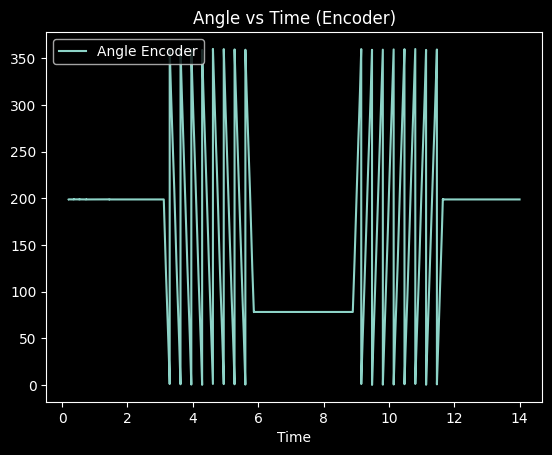

In [56]:
# Map raw angle (0-4095) to degrees (0-360)
df_encoder['Angle Encoder'] = df_encoder['Raw Angle'] / 4095 * 360

df_encoder.plot(x='Time', y='Angle Encoder', title='Angle vs Time (Encoder)')

<Axes: title={'center': 'Angle vs Time (Encoder)'}, xlabel='Time'>

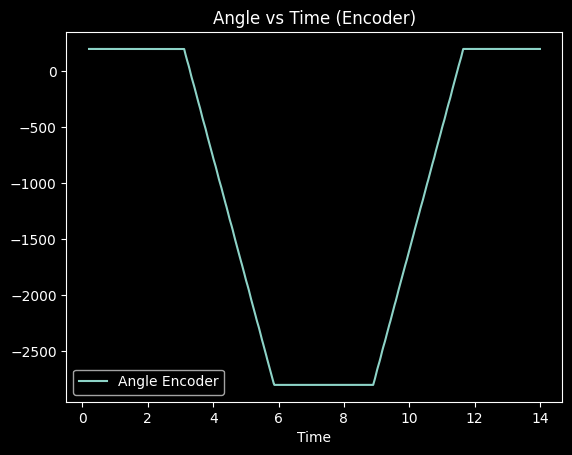

In [57]:
# Continuous angle
continuous_angle = [df_encoder['Angle Encoder'].iloc[0]]

# Calculate into continuous angle
for i in range(1, len(df_encoder)):
    delta_angle = df_encoder['Angle Encoder'][i] - df_encoder['Angle Encoder'][i - 1]
    if delta_angle > 180:
        delta_angle -= 360
    elif delta_angle < -180:
        delta_angle += 360

    continuous_angle.append(continuous_angle[-1] + delta_angle)

df_encoder['Angle Encoder'] = continuous_angle

df_encoder.plot(x='Time', y='Angle Encoder', title='Angle vs Time (Encoder)')

In [58]:
#calibrate the encoder
df_encoder['Angle Encoder'] = df_encoder['Angle Encoder'] - df_encoder['Angle Encoder'].iloc[0]

<Axes: title={'center': 'Angle vs Time (Encoder)'}, xlabel='Time'>

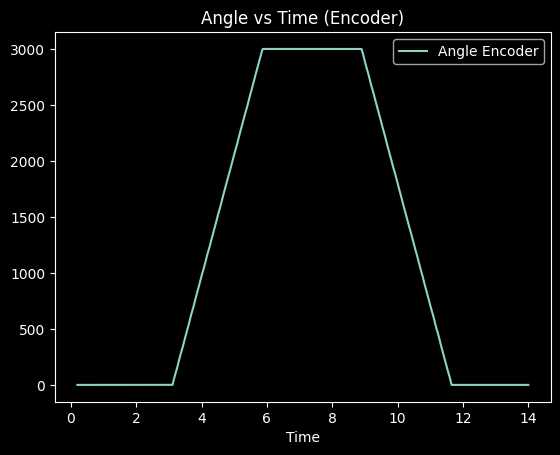

In [59]:
# Change direction of angle
df_encoder['Angle Encoder'] = -df_encoder['Angle Encoder']

df_encoder.plot(x='Time', y='Angle Encoder', title='Angle vs Time (Encoder)')

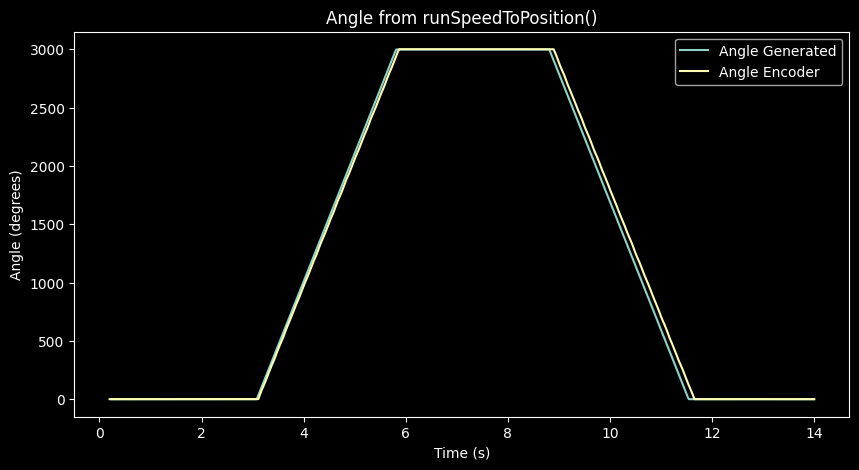

In [60]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

ax.plot(df['Time'], df['Angle Generated'], label='Angle Generated')
ax.plot(df_encoder['Time'], df_encoder['Angle Encoder'], label='Angle Encoder')

ax.set_title('Angle from runSpeedToPosition()')
ax.set_xlabel('Time (s)')
ax.set_ylabel('Angle (degrees)')

ax.legend()

In [61]:
# dfEncoder['Radian'] = np.deg2rad(dfEncoder['Angle'])
# dfEncoder['Velocity'] = dfEncoder['Radian'].diff() / dfEncoder['Time'].diff()
df_encoder['Velocity Encoder'] = df_encoder['Angle Encoder'].diff() / df_encoder['Time'].diff()
df_encoder['Velocity Encoder'] = df_encoder['Velocity Encoder'].fillna(0)

df_encoder['Acceleration Encoder'] = df_encoder['Velocity Encoder'].diff() / df_encoder['Time'].diff()
df_encoder['Acceleration Encoder'] = df_encoder['Acceleration Encoder'].fillna(0)

df_encoder.head()

,Raw Angle,Time,Angle Encoder,Velocity Encoder,Acceleration Encoder
0,2260,0.200,-0.000000,0.000000,0.000000
1,2261,0.201,-0.087912,-87.912088,-87912.087912
2,2261,0.202,-0.087912,0.000000,87912.087912
3,2261,0.203,-0.087912,0.000000,0.000000
4,2261,0.204,-0.087912,0.000000,0.000000


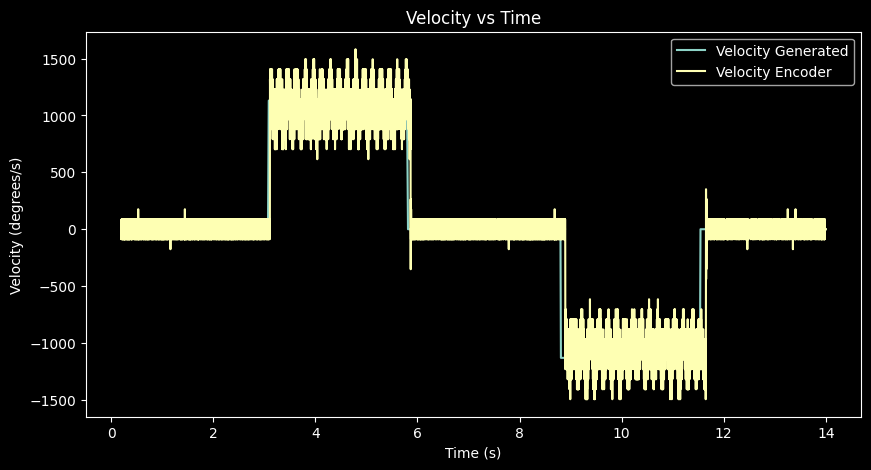

In [62]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

ax.plot(df['Time'], df['Velocity Generated'], label='Velocity Generated')
ax.plot(df_encoder['Time'], df_encoder['Velocity Encoder'], label='Velocity Encoder')

ax.set_title('Velocity vs Time')
ax.set_xlabel('Time (s)')
ax.set_ylabel('Velocity (degrees/s)')

ax.legend()

In [63]:
# columnsDF = ['Position', 'Angle', 'Radian', 'Velocity', 'Acceleration', 'Started', 'Time']
# columnsDFEncoder = ['Raw Angle', 'Angle', 'Radian', 'Velocity', 'Acceleration', 'Match Flag', 'Started', 'Time']

columnsDF = ['Position Generated', 'Angle Generated', 'Velocity Generated', 'Acceleration Generated', 'Time']
columnsDFEncoder = ['Raw Angle', 'Angle Encoder', 'Velocity Encoder', 'Acceleration Encoder', 'Time']

df = df[columnsDF]
df_encoder = df_encoder[columnsDFEncoder]

# **GRAPH**

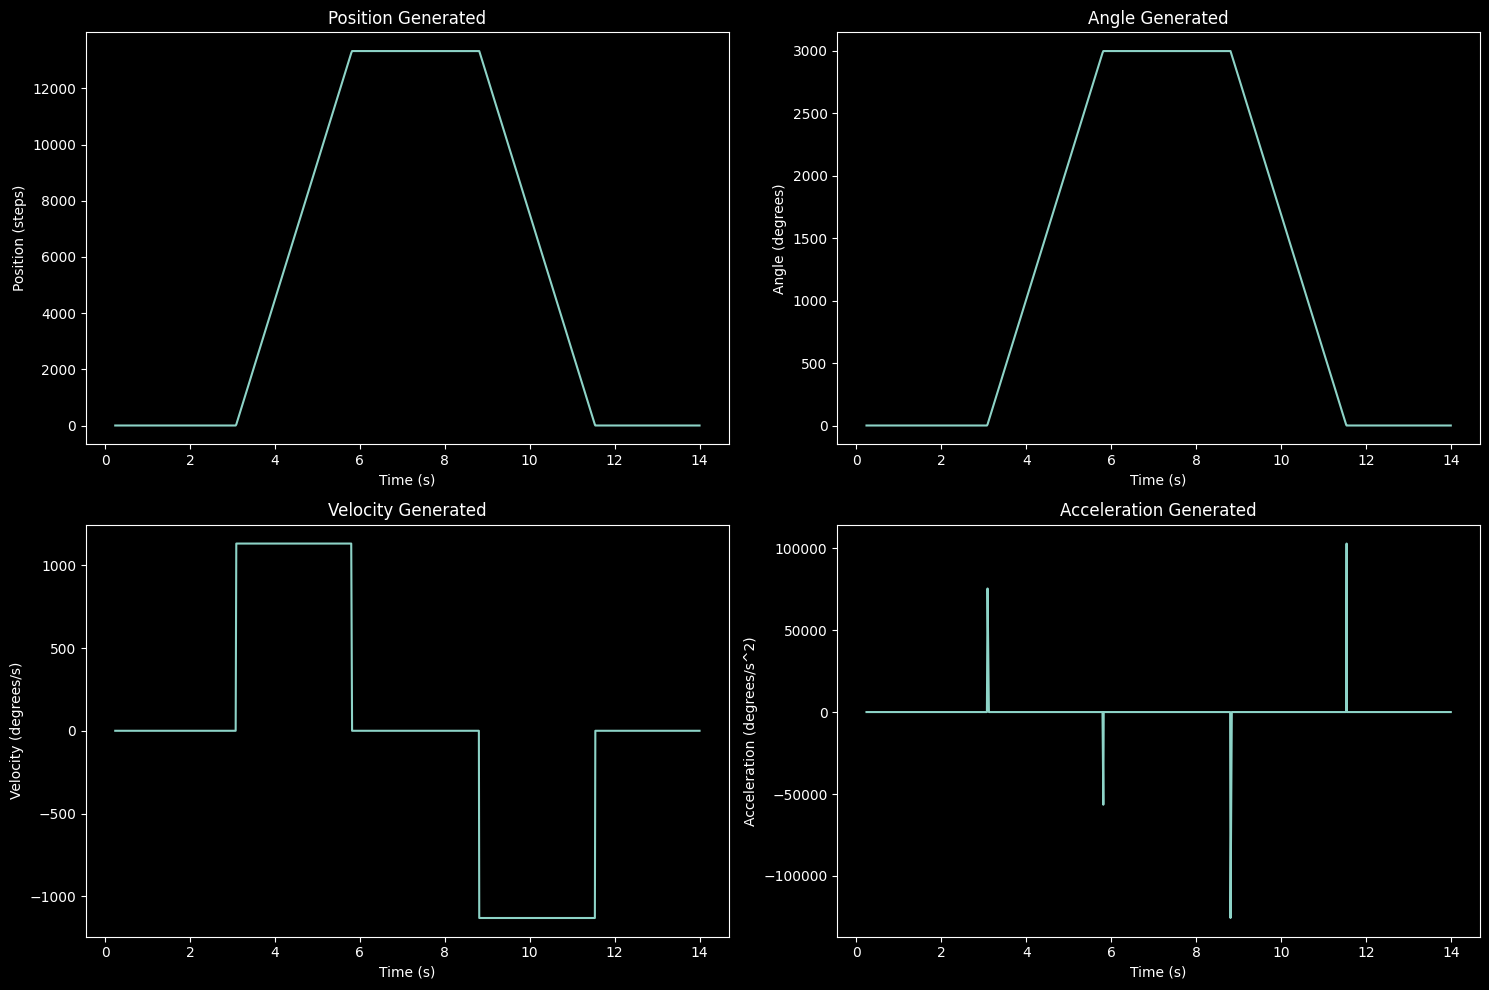

In [64]:
units = ['steps', 'degrees', 'degrees/s', 'degrees/s^2', 's']

fig, ax = plt.subplots((len(columnsDF)) // 2, 2, figsize=(15, 10))
for i, col in enumerate(columnsDF):
    if col == 'Time':
        continue
    ax[i // 2, i % 2].plot(df['Time'], df[col])
    ax[i // 2, i % 2].set_title(col)
    ax[i // 2, i % 2].set_xlabel('Time (s)')
    ax[i // 2, i % 2].set_ylabel(col.split(' ')[0] + ' (' + units[i] + ')')

fig.tight_layout()

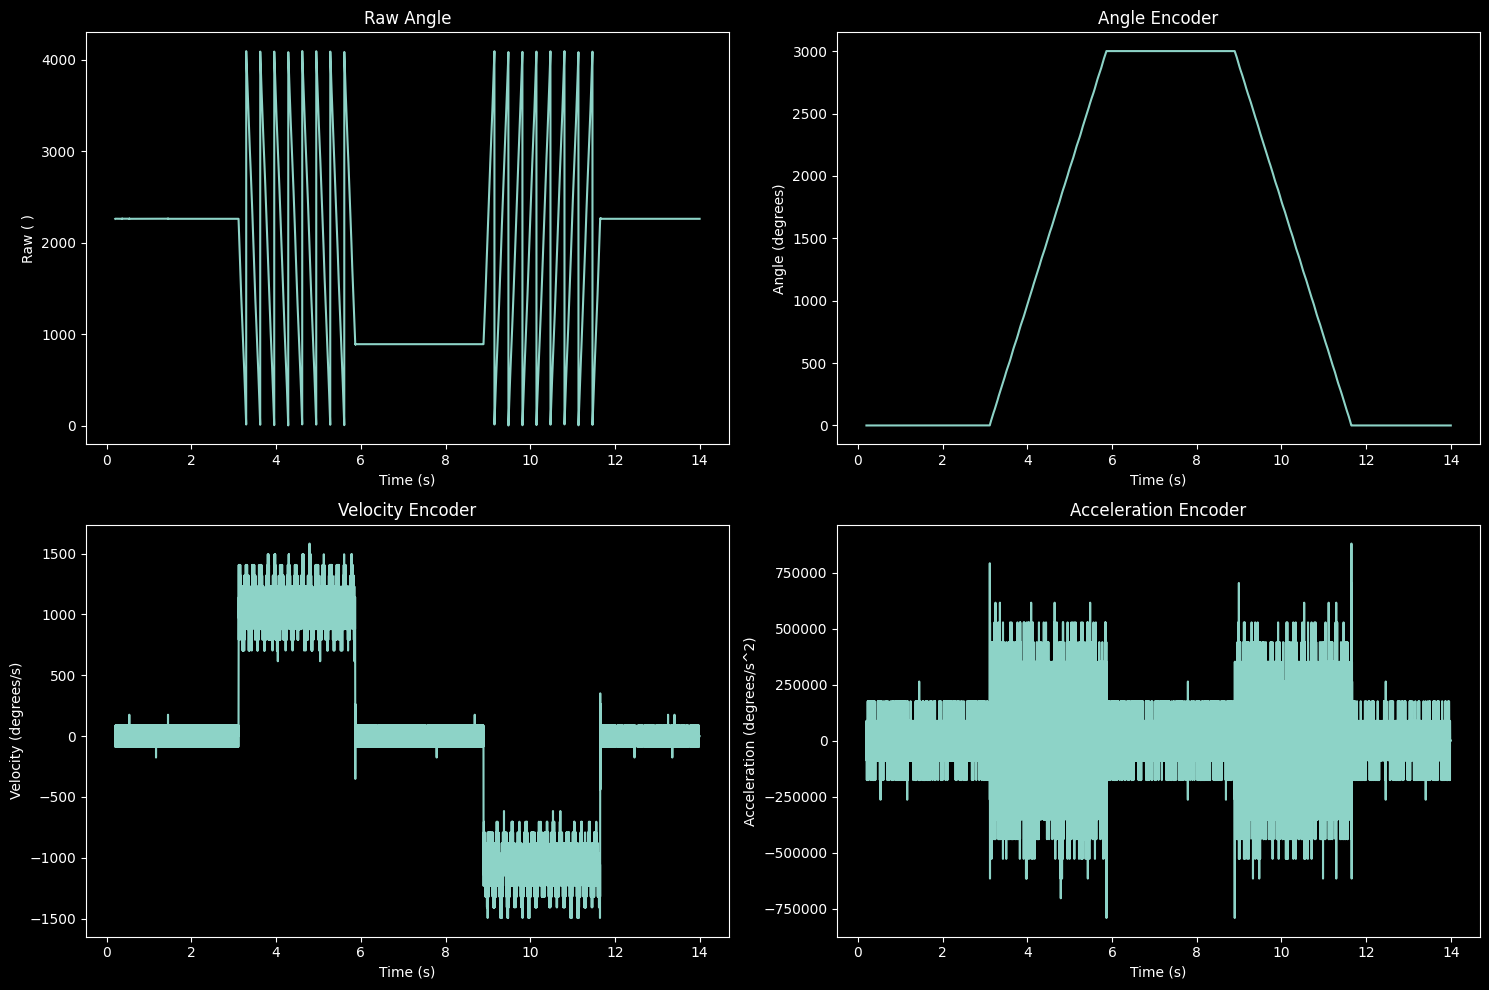

In [65]:
units = [' ', 'degrees', 'degrees/s', 'degrees/s^2', 's']

fig, ax = plt.subplots((len(columnsDFEncoder)) // 2, 2, figsize=(15, 10))
for i, col in enumerate(columnsDFEncoder):
    if col == 'Time':
        continue
    ax[i // 2, i % 2].plot(df_encoder['Time'], df_encoder[col])
    ax[i // 2, i % 2].set_title(col)
    ax[i // 2, i % 2].set_xlabel('Time (s)')
    ax[i // 2, i % 2].set_ylabel(col.split(' ')[0] + ' (' + units[i] + ')')

fig.tight_layout()

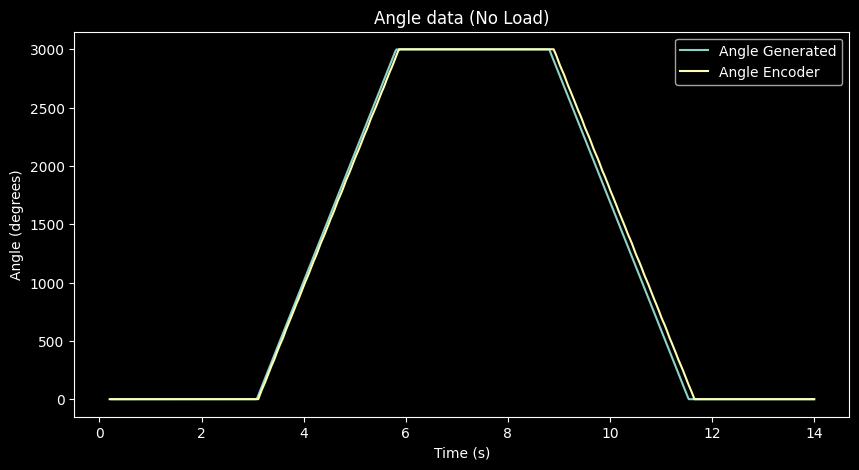

In [66]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(df['Time'], df['Angle Generated'], label='Angle Generated')
ax.plot(df_encoder['Time'], df_encoder['Angle Encoder'], label='Angle Encoder')

ax.set_title('Angle data (No Load)')
ax.set_xlabel('Time (s)')
ax.set_ylabel('Angle (degrees)')
ax.legend()

In [67]:
df['Angle Generated'].max(), df_encoder['Angle Encoder'].max()

(2998.575, 3000.703296703313)

Text(0, 0.5, 'Velocity (degrees/s)')

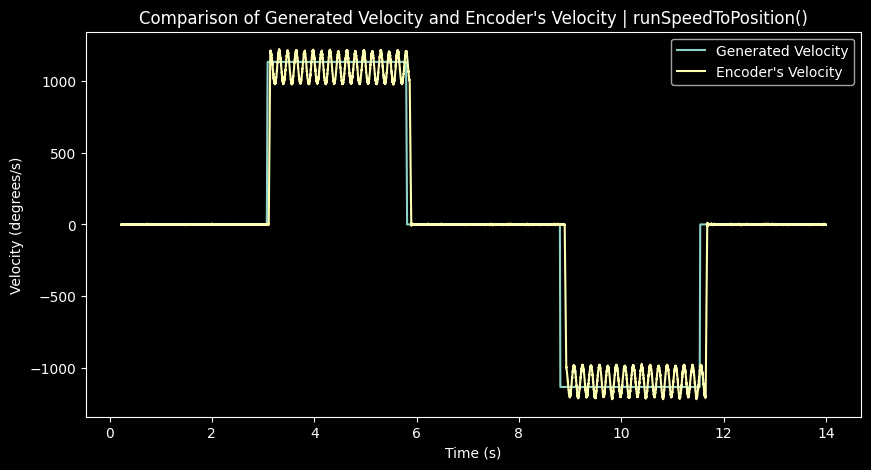

In [68]:
dfCopy = df_encoder.copy()

# Apply filter to velocity
dfCopy['Velocity Encoder Filtered'] = dfCopy['Velocity Encoder'].rolling(window=30).mean()

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
# ax.plot(dfCopy['Time'], dfCopy['Velocity Encoder'])
# ax.plot(dfCopy['Time'], dfCopy['Velocity Encoder Filtered'])
# ax[1].plot(dfCopy['Time'], dfCopy['Velocity Encoder Filtered'])
ax.plot(df['Time'], df['Velocity Generated'])
ax.plot(dfCopy['Time'], dfCopy['Velocity Encoder Filtered'])

# ax.set_title('Velocity using runSpeedToPosition()')
# ax[1].set_title('Filtered Velocity (Encoder)')
ax.set_title('Comparison of Generated Velocity and Encoder\'s Velocity | runSpeedToPosition()')

# ax.legend(['Raw Velocity', 'Filtered Velocity'])
# ax[1].legend(['Filtered Velocity'])
ax.legend(['Generated Velocity', 'Encoder\'s Velocity'])

ax.set_xlabel('Time (s)')
ax.set_ylabel('Velocity (degrees/s)')

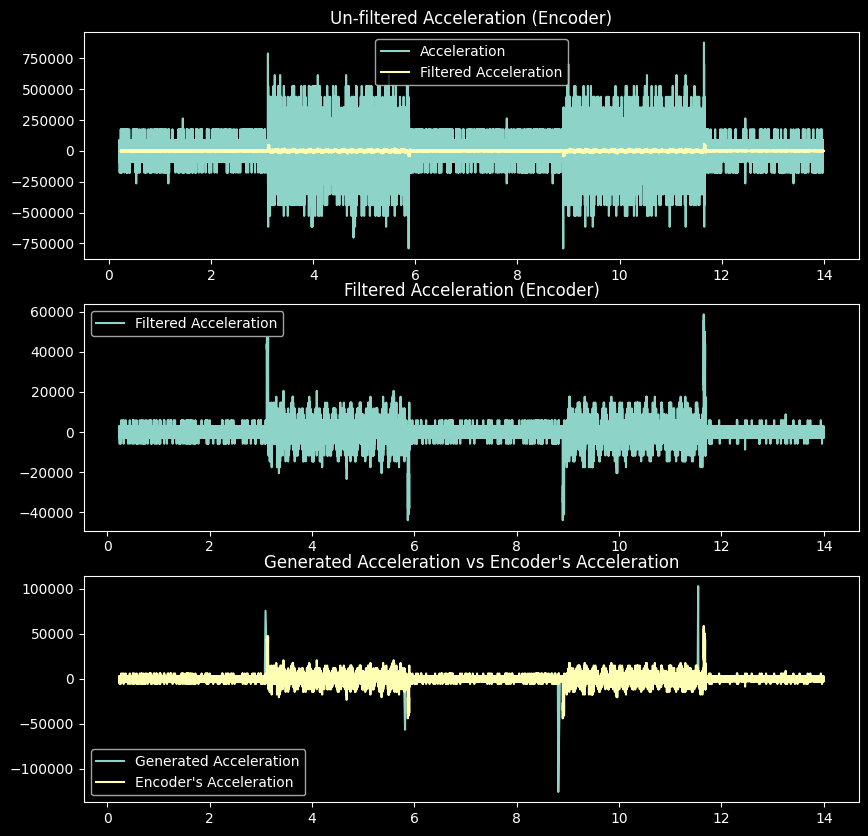

In [69]:
dfCopy['Acceleration Encoder Filtered'] = dfCopy['Acceleration Encoder'].rolling(window=30).mean()

fig, ax = plt.subplots(3, 1, figsize=(10, 10))
ax[0].plot(dfCopy['Time'], dfCopy['Acceleration Encoder'])
ax[0].plot(dfCopy['Time'], dfCopy['Acceleration Encoder Filtered'])
ax[1].plot(dfCopy['Time'], dfCopy['Acceleration Encoder Filtered'])
ax[2].plot(df['Time'], df['Acceleration Generated'])
ax[2].plot(dfCopy['Time'], dfCopy['Acceleration Encoder Filtered'])

ax[0].set_title('Un-filtered Acceleration (Encoder)')
ax[1].set_title('Filtered Acceleration (Encoder)')
ax[2].set_title('Generated Acceleration vs Encoder\'s Acceleration')

ax[0].legend(['Acceleration', 'Filtered Acceleration'])
ax[1].legend(['Filtered Acceleration'])
ax[2].legend(['Generated Acceleration', 'Encoder\'s Acceleration'])

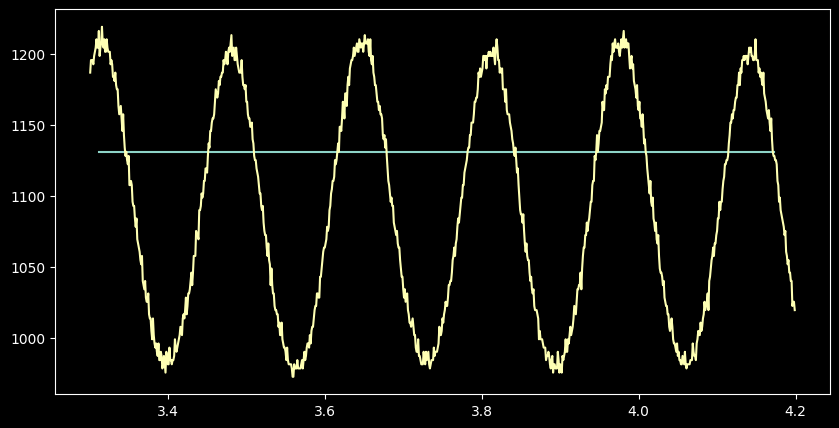

In [70]:
df_3_4 = df[(df['Time'] > 3.3) & (df['Time'] < 4.2)]
df_encoder_3_4 = dfCopy[(dfCopy['Time'] > 3.3) & (dfCopy['Time'] < 4.2)]

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(df_3_4['Time'], df_3_4['Velocity Generated'], label='Velocity Generated')
ax.plot(df_encoder_3_4['Time'], df_encoder_3_4['Velocity Encoder Filtered'], label='Velocity Encoder Filtered')

In [71]:
df_encoder_3_4['Velocity Encoder Filtered'].mean()

1092.8870906623963

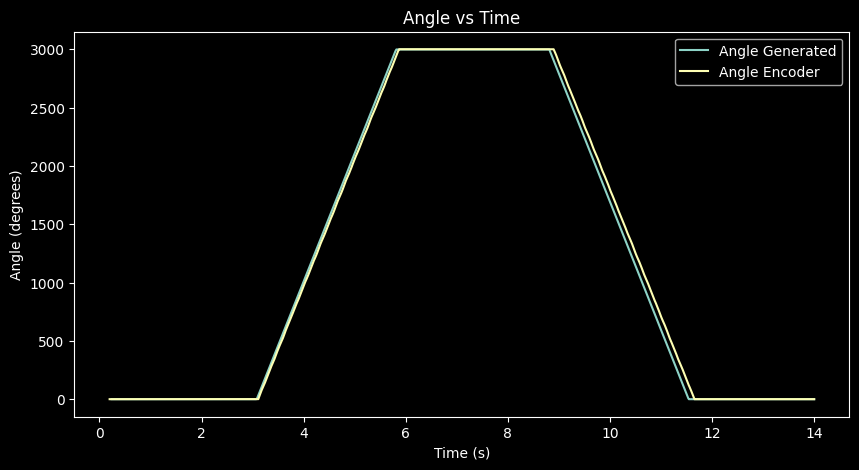

In [72]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

ax.plot(df['Time'], df['Angle Generated'], label='Angle Generated')
ax.plot(df_encoder['Time'], df_encoder['Angle Encoder'], label='Angle Encoder')

ax.set_title('Angle vs Time')
ax.set_xlabel('Time (s)')
ax.set_ylabel('Angle (degrees)')

ax.legend()

,Position Generated,Angle Generated,Velocity Generated,Acceleration Generated,Time,Diff
304,38,8.55,1130.892737,75392.849121,3.089,1130.892737


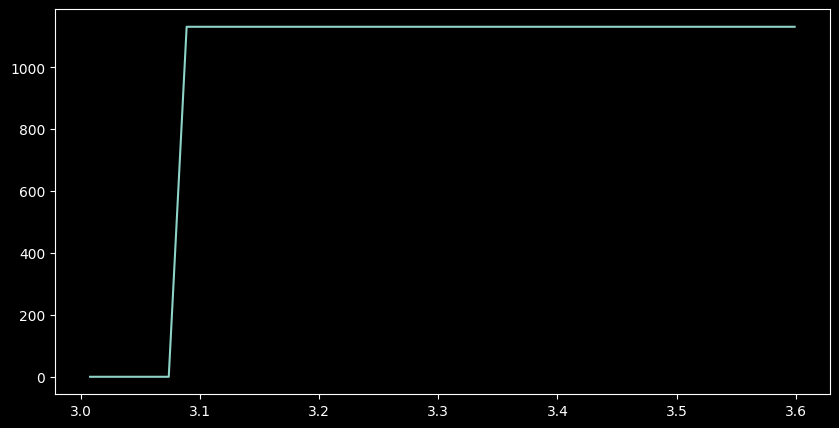

In [73]:
dfTemp = df[(df['Time'] > 3) & (df['Time'] < 3.6)]

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(dfTemp['Time'], dfTemp['Velocity Generated'], label='Velocity Generated')

dfTemp['Diff'] = dfTemp['Velocity Generated'].diff()
dfTemp = dfTemp[(dfTemp['Diff'] > 0)]

dfTemp.head(10)

In [74]:
startTime = dfTemp['Time'].iloc[0]

,Position Generated,Angle Generated,Velocity Generated,Acceleration Generated,Time,Diff
390,13327,2998.575,0.0,-56544.636841,5.816,-1130.892737


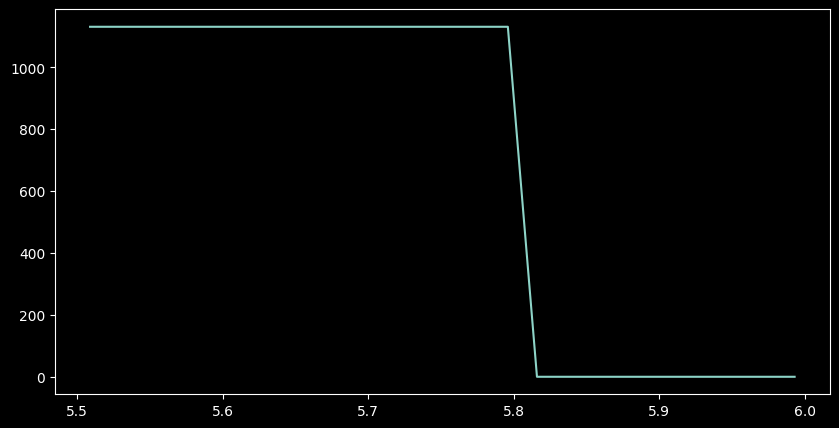

In [75]:
dfTemp = df[(df['Time'] > 5.5) & (df['Time'] < 6)]

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(dfTemp['Time'], dfTemp['Velocity Generated'], label='Velocity Generated')

dfTemp['Diff'] = dfTemp['Velocity Generated'].diff()
dfTemp = dfTemp[(dfTemp['Diff'] < 0)]

dfTemp.head(10)

In [76]:
endTime = dfTemp['Time'].iloc[0]

endTime - startTime

2.727

,Raw Angle,Angle Encoder,Velocity Encoder,Acceleration Encoder,Time,Diff
2912,2254,0.527473,527.472527,527472.527473,3.112,0.527473
2913,2239,1.846154,1318.681319,791208.791209,3.113,1.318681
2914,2227,2.901099,1054.945055,-263736.263736,3.114,1.054945
2915,2213,4.131868,1230.769231,175824.175824,3.115,1.230769
2916,2198,5.450549,1318.681319,87912.087913,3.116,1.318681
2917,2182,6.857143,1406.593407,87912.087912,3.117,1.406593
2918,2173,7.648352,791.208791,-615384.615385,3.118,0.791209
2919,2158,8.967033,1318.681319,527472.527472,3.119,1.318681
2920,2145,10.109890,1142.857143,-175824.175824,3.120,1.142857
2921,2134,11.076923,967.032967,-175824.175824,3.121,0.967033


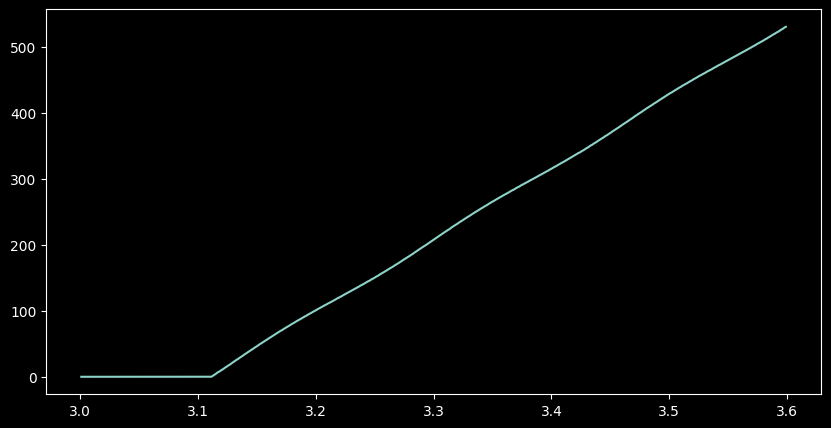

In [77]:
dfTemp = df_encoder[(df_encoder['Time'] > 3) & (df_encoder['Time'] < 3.6)]

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(dfTemp['Time'], dfTemp['Angle Encoder'], label='Angle Encoder')

dfTemp['Diff'] = dfTemp['Angle Encoder'].diff()
dfTemp = dfTemp[(dfTemp['Diff'] > 0.3)]

dfTemp.head(10)

In [78]:
startTime = dfTemp['Time'].iloc[0]

,Raw Angle,Angle Encoder,Velocity Encoder,Acceleration Encoder,Time,Diff
5669,891,3000.351648,-351.648352,-351648.351649,5.869,-0.351648


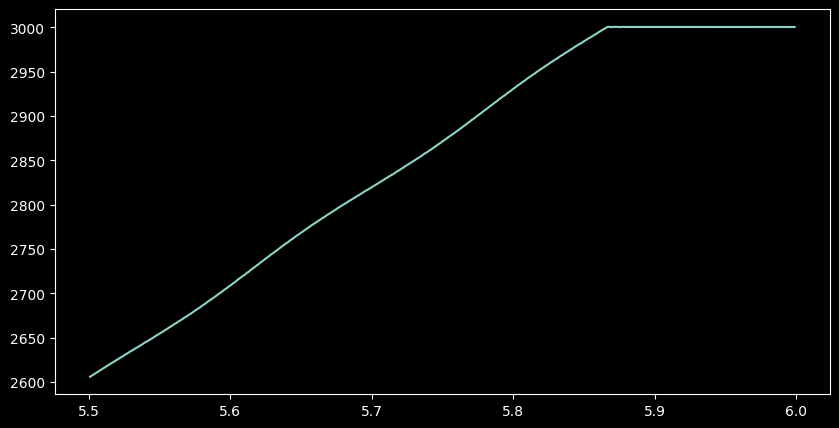

In [79]:
dfTemp = df_encoder[(df_encoder['Time'] > 5.5) & (df_encoder['Time'] < 6)]

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(dfTemp['Time'], dfTemp['Angle Encoder'], label='Angle Encoder')

dfTemp['Diff'] = dfTemp['Angle Encoder'].diff()
dfTemp = dfTemp[(dfTemp['Diff'] < -0.1)]

dfTemp.head(10)

In [80]:
endTime = dfTemp['Time'].iloc[0]

endTime - startTime

2.7569999999999997

In [81]:
df.max()

Position Generated         13327.000000
Angle Generated             2998.575000
Velocity Generated          1130.892737
Acceleration Generated    102808.430620
Time                          13.999000
dtype: float64

In [82]:
dfCopy.max()

Raw Angle                          4094.000000
Angle Encoder                      3000.703297
Velocity Encoder                   1582.417582
Acceleration Encoder             879120.879120
Time                                 13.999000
Velocity Encoder Filtered          1219.047619
Acceleration Encoder Filtered     58608.058608
dtype: float64